# SpaceNet Validation Visualizations
Random validation tiles with model predictions.

In [32]:
from pathlib import Path
import random
import numpy as np
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from transformers import SegformerForSemanticSegmentation

# --- CONFIG ---
DATA_ROOT = Path('tiles_paris_rgb')
VAL_IMG = DATA_ROOT / 'val/images'
VAL_MSK = DATA_ROOT / 'val/masks'
CKPT_PATH = Path('best_segformer_vegas.pth')  # or checkpoints/latest_segformer_vegas.pth
NUM_SAMPLES = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'


In [33]:
# Load model
model = SegformerForSemanticSegmentation.from_pretrained(
    'nvidia/segformer-b2-finetuned-ade-512-512',
    num_labels=2,
    ignore_mismatched_sizes=True,
).to(DEVICE)
state = torch.load(CKPT_PATH, map_location='cpu')
if isinstance(state, dict) and 'model_state_dict' in state:
    model.load_state_dict(state['model_state_dict'], strict=False)
else:
    model.load_state_dict(state, strict=False)
model.eval()


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b2-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([2, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [29]:
# Pick random samples
all_imgs = sorted(VAL_IMG.glob('*.png'))
assert all_imgs, f'No images found in {VAL_IMG}'
rng = random.Random(1)
samples = rng.sample(all_imgs, k=min(NUM_SAMPLES, len(all_imgs)))
samples


[PosixPath('tiles_paris_rgb/val/images/RGB-PanSharpen_AOI_3_Paris_img1263_x0_y138.png'),
 PosixPath('tiles_paris_rgb/val/images/RGB-PanSharpen_AOI_3_Paris_img344_x138_y0.png'),
 PosixPath('tiles_paris_rgb/val/images/RGB-PanSharpen_AOI_3_Paris_img897_x138_y138.png'),
 PosixPath('tiles_paris_rgb/val/images/RGB-PanSharpen_AOI_3_Paris_img767_x0_y138.png')]

In [30]:
def load_pair(img_path: Path):
    img = np.array(Image.open(img_path).convert('RGB'))
    msk = np.array(Image.open(VAL_MSK / img_path.name))
    msk = (msk > 0).astype(np.uint8)
    return img, msk

def predict(img: np.ndarray):
    x = torch.from_numpy(img).permute(2,0,1).float() / 255.0
    x = x.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        out = model(pixel_values=x)
        logits = F.interpolate(out.logits, size=img.shape[:2], mode='bilinear', align_corners=False)
        pred = logits.argmax(1).squeeze(0).cpu().numpy().astype(np.uint8)
    return pred


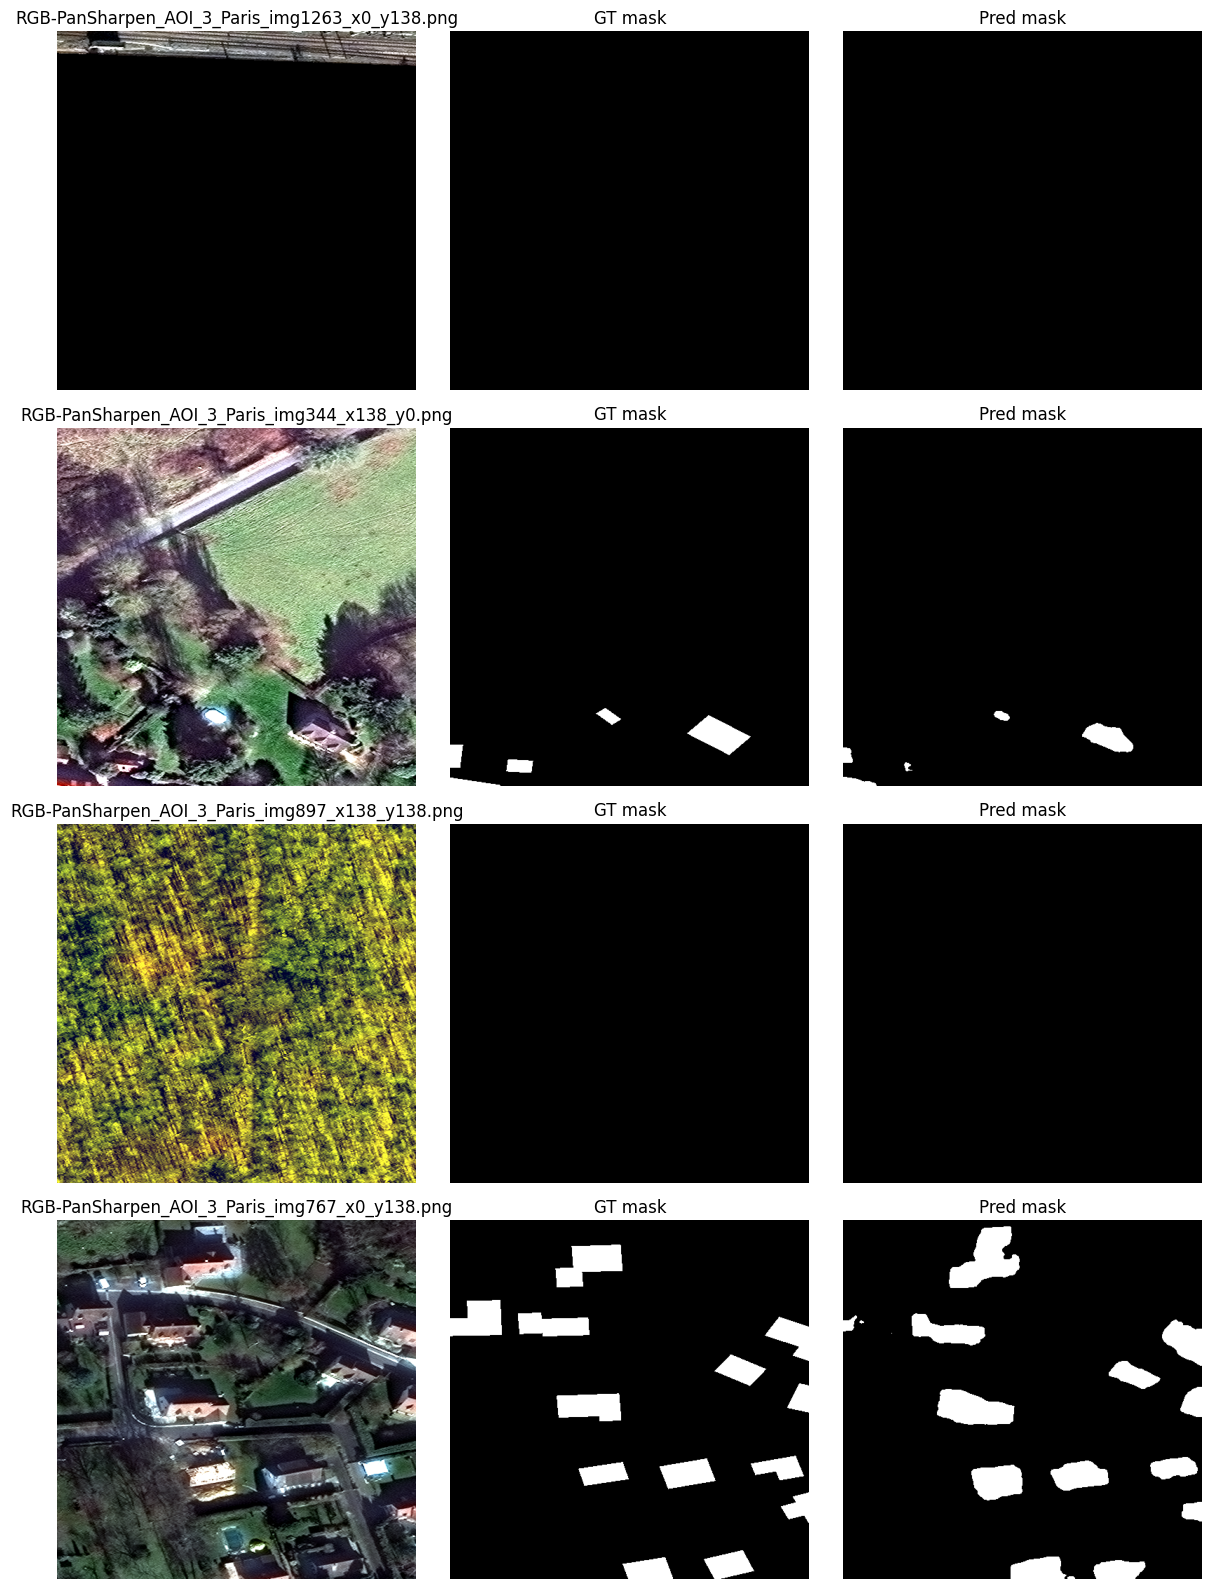

In [34]:
# Visualize
cols = 3
rows = len(samples)
plt.figure(figsize=(cols*4, rows*4))
for i, p in enumerate(samples):
    img, msk = load_pair(p)
    pred = predict(img)

    ax = plt.subplot(rows, cols, i*cols + 1)
    ax.imshow(img)
    ax.set_title(p.name)
    ax.axis('off')

    ax = plt.subplot(rows, cols, i*cols + 2)
    ax.imshow(msk, cmap='gray')
    ax.set_title('GT mask')
    ax.axis('off')

    ax = plt.subplot(rows, cols, i*cols + 3)
    ax.imshow(pred, cmap='gray')
    ax.set_title('Pred mask')
    ax.axis('off')

plt.tight_layout()
plt.show()


## SpaceNet-style Polygon F1 (Approx)
This approximates the official SpaceNet building F1 by polygonizing masks and
matching predicted polygons to ground truth polygons with IoU >= 0.5 (greedy).

In [16]:
import cv2
from shapely.geometry import Polygon
from shapely.ops import unary_union

def mask_to_polygons(mask, min_area=10):
    # mask: (H,W) uint8 0/1
    cnts, _ = cv2.findContours(mask.astype('uint8'), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polys = []
    for c in cnts:
        if len(c) < 3:
            continue
        poly = Polygon(c[:, 0, :])
        if not poly.is_valid or poly.area < min_area:
            continue
        polys.append(poly)
    return polys

def polygon_iou(a: Polygon, b: Polygon) -> float:
    inter = a.intersection(b).area
    union = a.union(b).area
    return inter / union if union > 0 else 0.0

def greedy_match(pred_polys, gt_polys, iou_thresh=0.5):
    # Compute all IoUs
    pairs = []
    for i, p in enumerate(pred_polys):
        for j, g in enumerate(gt_polys):
            iou = polygon_iou(p, g)
            if iou >= iou_thresh:
                pairs.append((iou, i, j))
    pairs.sort(reverse=True, key=lambda x: x[0])

    matched_pred = set()
    matched_gt = set()
    tp = 0
    for iou, i, j in pairs:
        if i in matched_pred or j in matched_gt:
            continue
        matched_pred.add(i)
        matched_gt.add(j)
        tp += 1

    fp = len(pred_polys) - len(matched_pred)
    fn = len(gt_polys) - len(matched_gt)
    return tp, fp, fn

def f1_from_counts(tp, fp, fn):
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    return 2 * prec * rec / (prec + rec) if (prec + rec) > 0 else 0.0


In [17]:
# Evaluate on a subset of val tiles (set N=None for full val)
N = None
iou_thresh = 0.5
min_area = 10

all_imgs = sorted(VAL_IMG.glob('*.png'))
if N is not None:
    rng = random.Random(5)
    eval_imgs = rng.sample(all_imgs, k=min(N, len(all_imgs)))
else:
    eval_imgs = all_imgs

tp_total = fp_total = fn_total = 0
for p in eval_imgs:
    img, gt_mask = load_pair(p)
    pred_mask = predict(img)

    pred_polys = mask_to_polygons(pred_mask, min_area=min_area)
    gt_polys = mask_to_polygons(gt_mask, min_area=min_area)

    tp, fp, fn = greedy_match(pred_polys, gt_polys, iou_thresh=iou_thresh)
    tp_total += tp
    fp_total += fp
    fn_total += fn

f1 = f1_from_counts(tp_total, fp_total, fn_total)
print(f'Approx polygon F1 (IoU>={iou_thresh}): {f1:.4f}')
print(f'TP={tp_total} FP={fp_total} FN={fn_total} | N={len(eval_imgs)} tiles')


Approx polygon F1 (IoU>=0.5): 0.8153
TP=43202 FP=7147 FN=12430 | N=3188 tiles
